# IMPORT LIBS

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
# jupyter labextension install @jupyterlab/plotly-extension
import plotly.express as px
import json
import requests
from IPython.display import Image

# READ DATA

In [2]:
raw_path = './raw/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
olist_product_category_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

In [3]:
olist = (olist_orders
         .merge(olist_customer, on='customer_id')
         .merge(olist_order_items, on='order_id')
         .merge(olist_order_payments, on='order_id')
         .merge(olist_order_reviews, on='order_id')
         .merge(olist_products, on='product_id')
         .merge(olist_sellers, on='seller_id')
         .merge(olist_product_category_translation, on='product_category_name'))

In [4]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   customer_unique_id             115609 non-null  object 
 9   customer_zip_code_prefix       115609 non-null  int64  
 10  customer_city                  115609 non-null  object 
 11  customer_state                 115609 non-null  object 
 12  order_item_id                 

In [5]:
olist.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                             0
review_score                          0
review_comment_title             101808


In [6]:
olist['customer_id'].nunique()

96516

In [7]:
olist['seller_id'].nunique()

3028

In [8]:
olist['product_category_name'].nunique()

71

In [9]:
olist['product_id'].nunique()

32171

# DATA CLEANING

In [10]:
datetime_columns = ['review_creation_date','review_answer_timestamp','order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in datetime_columns:
    olist[datetime_columns] = olist[datetime_columns].apply(pd.to_datetime)

In [11]:
olist['review_response_time'] = (olist['review_answer_timestamp'] - olist['review_creation_date']).dt.days
olist['time_to_delivery'] = (olist['order_delivered_customer_date'] - olist['order_purchase_timestamp']).dt.days
olist['delivery_against_estimated'] = (olist['order_delivered_customer_date'] - olist['order_estimated_delivery_date']).dt.days
olist['product_volume_cm'] = olist['product_length_cm'] * olist['product_height_cm'] * olist['product_width_cm']

# Datetime parts
olist['order_purchase_year'] = olist.order_purchase_timestamp.dt.year
olist['order_purchase_year_month'] = olist.order_purchase_timestamp.dt.strftime('%Y %m')
olist['order_purchase_hour'] = olist.order_purchase_timestamp.dt.hour
olist['order_purchase_month'] = olist.order_purchase_timestamp.dt.month.map({
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May', 
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
})
olist['order_purchase_dayofweek'] = olist.order_purchase_timestamp.dt.dayofweek.map({
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
})

In [12]:
print(f'First observation was in: \
{olist_orders["order_purchase_timestamp"].min()}')
print(f'Last observation was in: \
{olist_orders["order_purchase_timestamp"].max()}')

First observation was in: 2016-09-04 21:15:19
Last observation was in: 2018-10-17 17:30:18


In [13]:
#dropna at olist_orders
olist.drop_duplicates(subset='order_id', inplace=True)

In [14]:
#dropna at olist_order_reviews
olist_order_reviews.drop_duplicates(subset='review_id', inplace=True)

In [15]:
olist['customer_city'] = olist['customer_city'].str.title()
olist['seller_city'] = olist['seller_city'].str.title()
olist['product_category_name_english'] = olist['product_category_name_english'].str.title().str.replace('_', ' ')
olist['payment_type'] = olist['payment_type'].str.replace('_', ' ').str.title()

In [16]:
#transfer data to date_time
olist['year'] = olist['order_purchase_timestamp'].dt.year
olist['month'] = olist['order_purchase_timestamp'].dt.month
olist['date'] = olist['order_purchase_timestamp'].dt.day.astype("Int64")

# EDA

## 1: What is the total revenue generated by Olist, and how has it changed over time?

In [17]:
olist['total_revenue'] = olist['price'] + olist['freight_value']

In [18]:
revenue_over_time = olist.groupby(['order_purchase_year_month'])['total_revenue'].sum().reset_index()
revenue_over_time

,order_purchase_year_month,total_revenue
0,2016 09,146.72
1,2016 10,50772.81
2,2016 12,19.62
3,2017 01,120295.25
4,2017 02,252869.05
5,2017 03,385919.31
6,2017 04,366680.26
7,2017 05,518721.77
8,2017 06,459223.35
9,2017 07,521534.09


C:\Users\trime\AppData\Local\Temp\ipykernel_11480\182511000.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



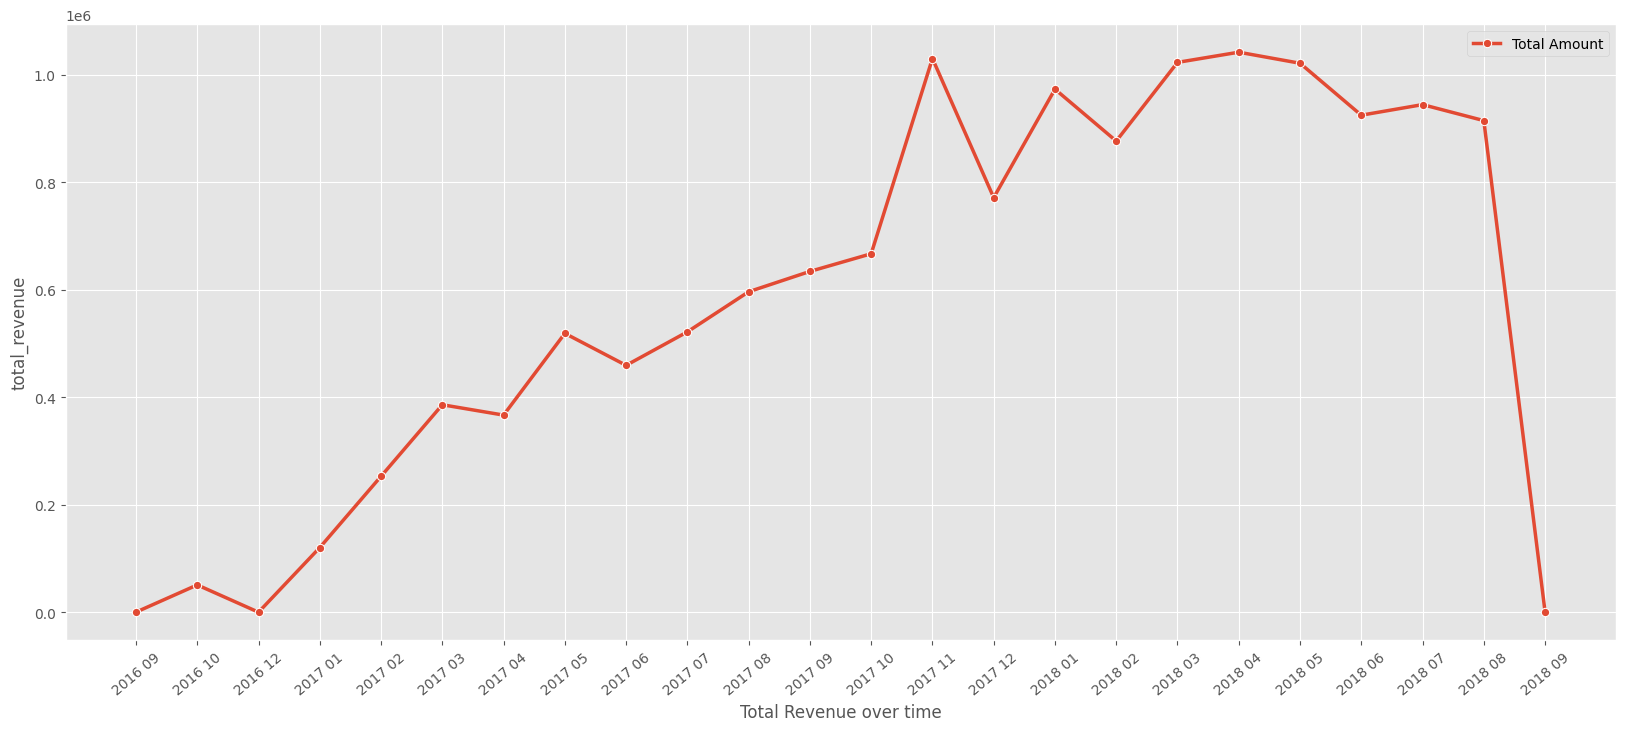

In [19]:
fig = plt.figure(figsize=(20, 8))
ax = sns.lineplot(x=revenue_over_time['order_purchase_year_month'].astype(str), y='total_revenue', data= revenue_over_time, linewidth=2.5, marker='o', label='Total Amount')
plt.xlabel('Total Revenue over time')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
plt.show()

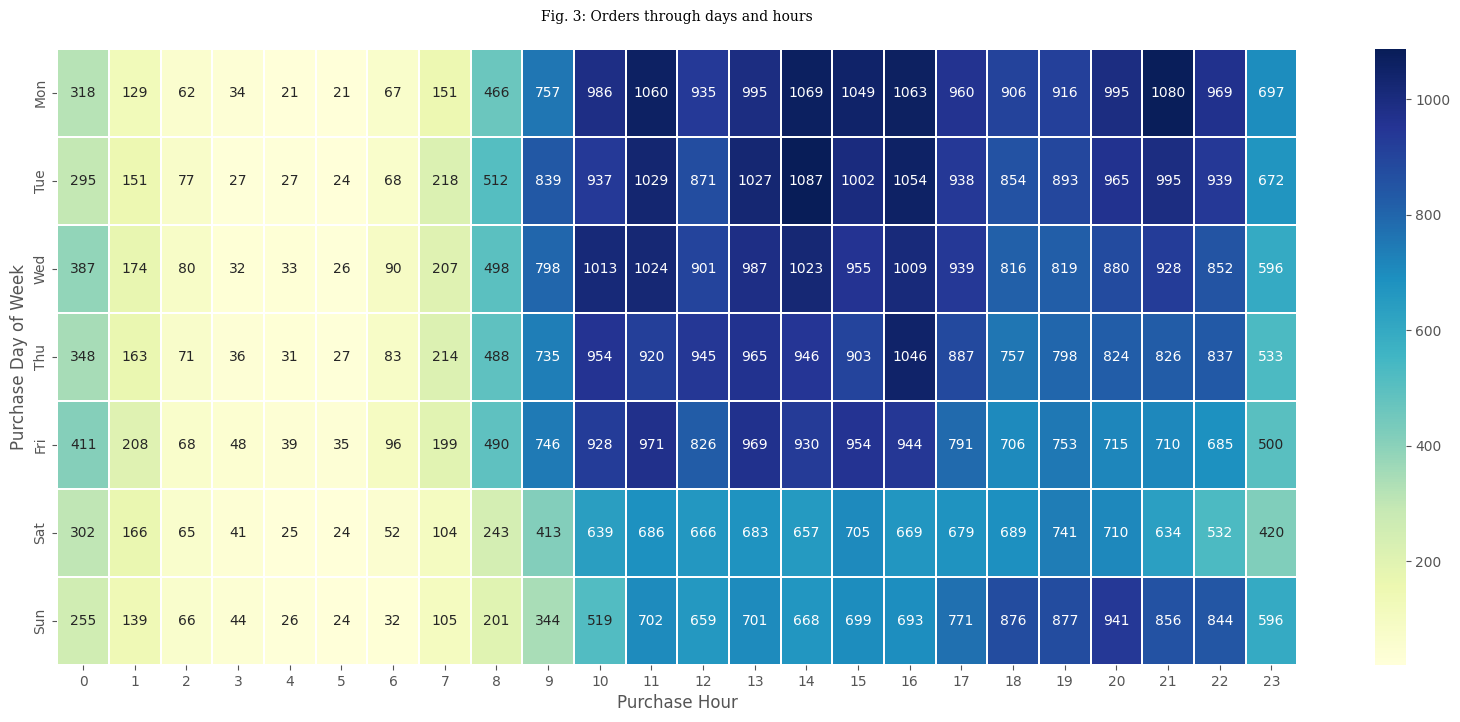

In [20]:
order_day_hour = olist.groupby(['order_purchase_dayofweek', 'order_purchase_hour'])['order_id'].nunique().unstack()
plt.figure(figsize=(20,8))
ax = sns.heatmap(order_day_hour.reindex(index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']), cmap="YlGnBu", annot=True, fmt="d", linewidths=0.2)
ax.set_xlabel('Purchase Hour')
ax.set_ylabel('Purchase Day of Week')
ax.set_title('Fig. 3: Orders through days and hours', size=14, font='serif', pad=20)
plt.show()

## 2:Total Orders on E-Commerce by status

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\3068963846.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\trime\AppData\Local\Temp\ipykernel_11480\3068963846.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



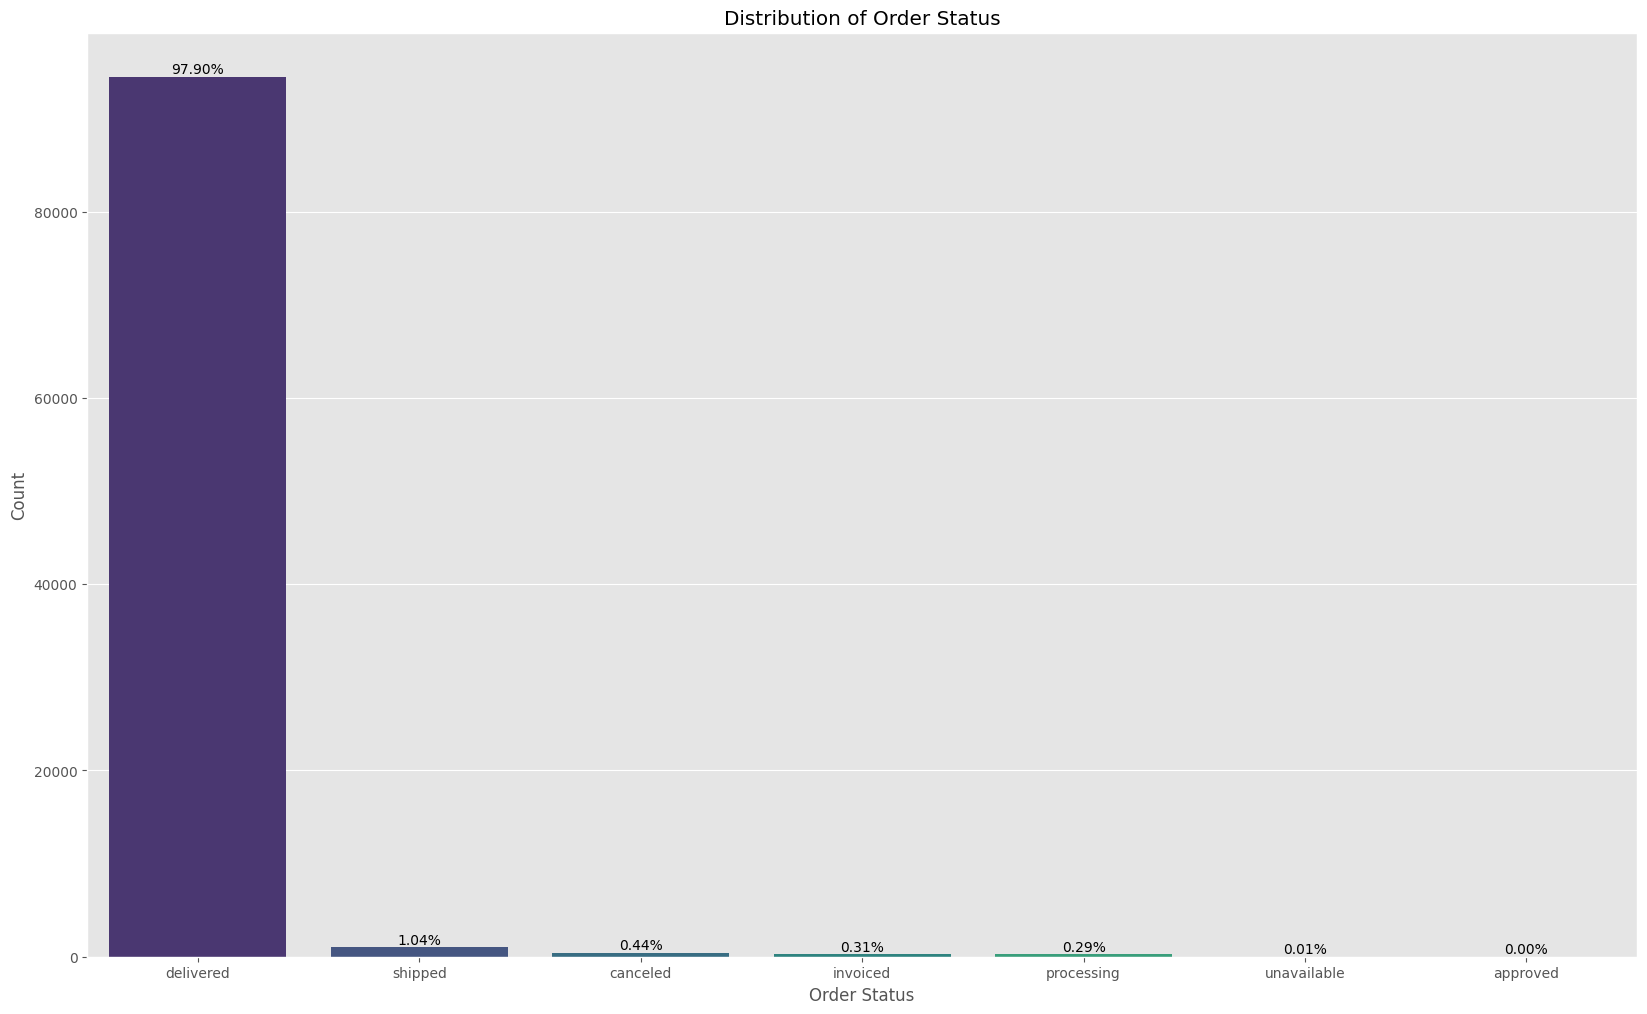

In [21]:
order_status_counts = olist['order_status'].value_counts()

# Calculate percentages
order_status_percentages = order_status_counts / order_status_counts.sum() * 100

# Create a bar plot
plt.figure(figsize=(20, 12))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values, palette='viridis')

# Add percentages above the bars
for i, percentage in enumerate(order_status_percentages):
    plt.text(i, order_status_counts[i] + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.title('Distribution of Order Status')

# Show the plot
plt.show()


## 3: Trend on brazilian e-commerce

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\3461809498.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



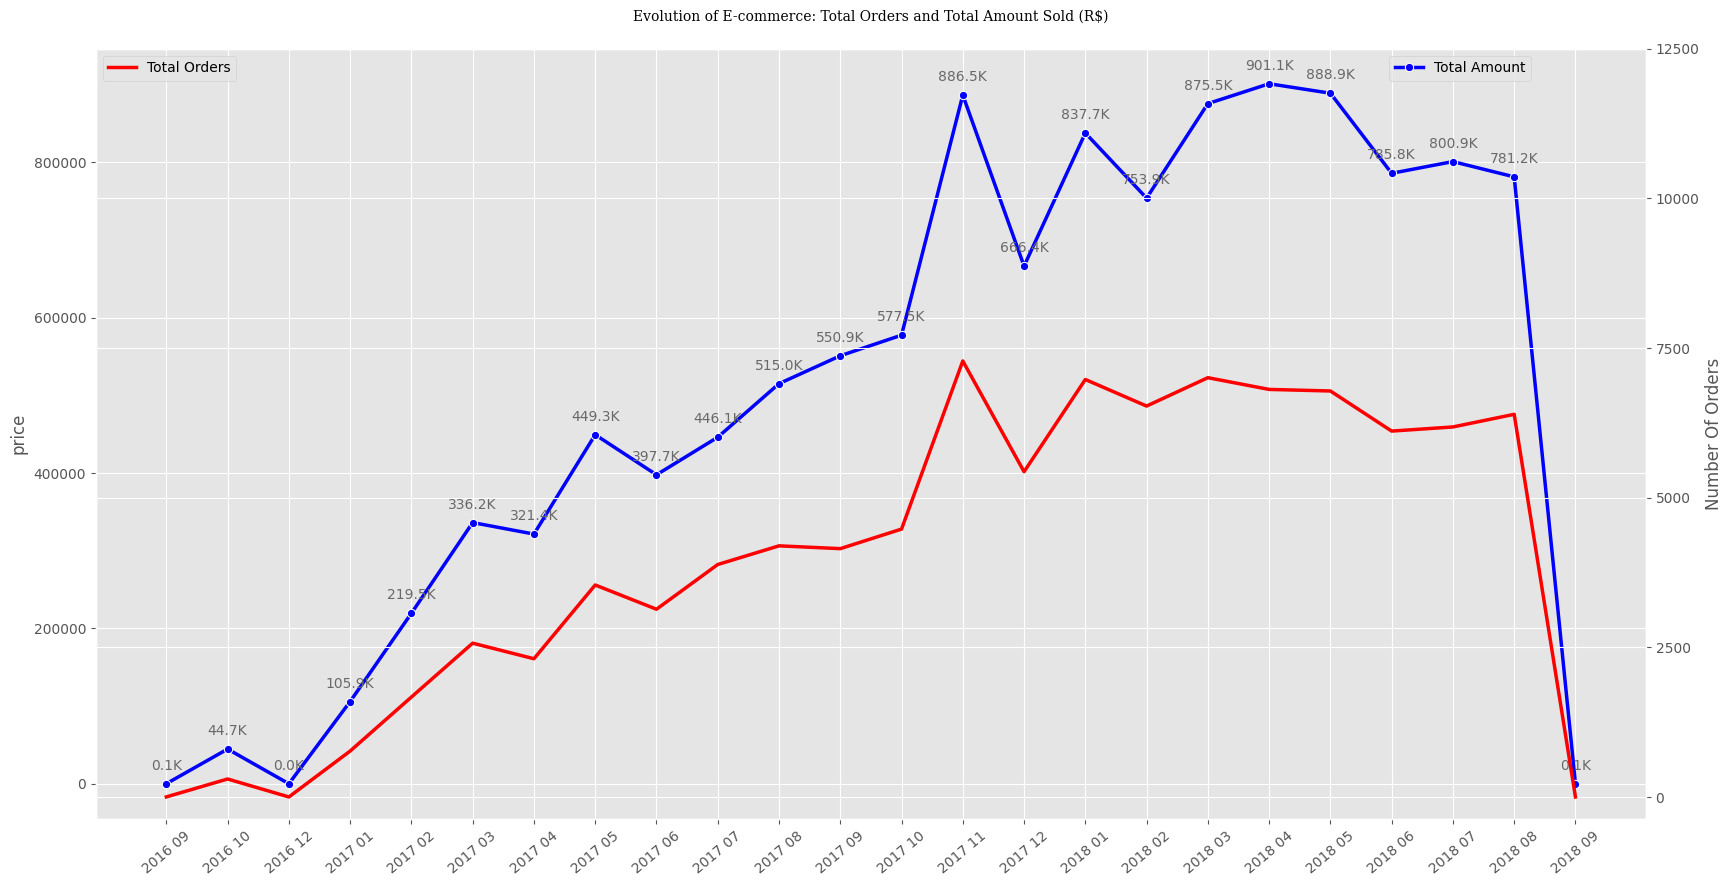

In [22]:
olist_sales_by_year_month = olist.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False).agg({
    'order_id': 'count',
    'price': 'sum'
})

fig = plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='order_purchase_year_month', y='price',color ='blue' ,data=olist_sales_by_year_month, linewidth=2.5, marker='o', label='Total Amount')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(0.83, 1))

ax1_twx = ax.twinx()
sns.lineplot(data=olist_sales_by_year_month, x='order_purchase_year_month', y='order_id', color='r', linewidth=2.5, ax=ax1_twx, label='Total Orders')
ax1_twx.legend(loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

ax1_twx.set_yticks(np.arange(0, 15000, 2500))
ax1_twx.set_ylabel('Number Of Orders')

for x, y in olist_sales_by_year_month.price.items():
    ax.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')
 

ax.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, font='serif', pad=20)
ax.set_xlabel('')
plt.show()

## 4: What are the most popular product categories on Olist?

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\4069877423.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




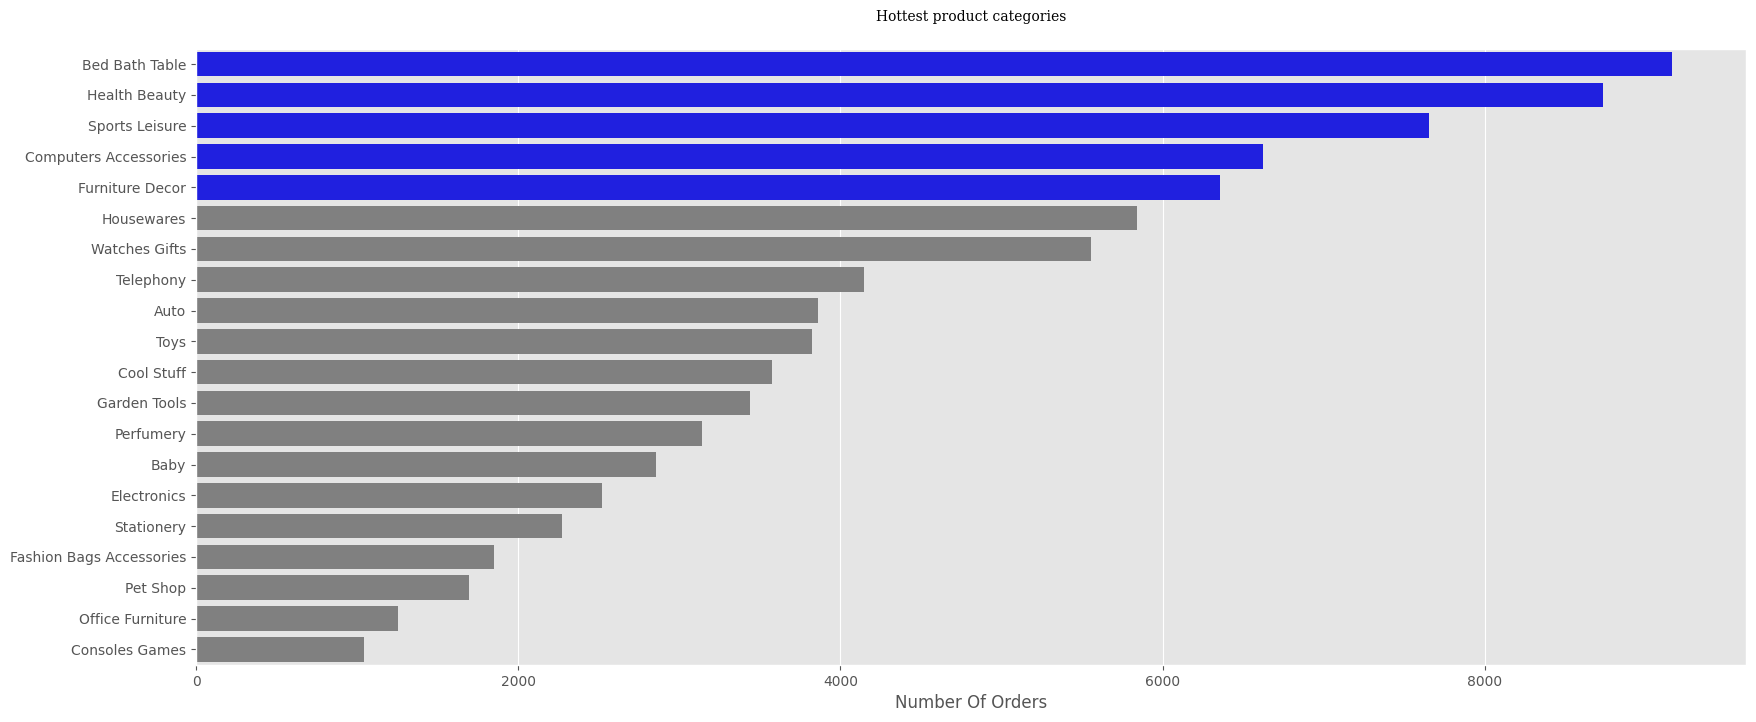

In [23]:
plt.figure(figsize=(20, 8))
order_by_product_categories = (olist
                  .groupby('product_category_name_english')['order_id'].count()
                  .reset_index()
                  .sort_values(by='order_id', ascending=False)
                  .head(20))
colors = ['grey' if (x < 6000) else 'blue' for x in order_by_product_categories.order_id]
ax = sns.barplot(data=order_by_product_categories,
            x='order_id',
            y='product_category_name_english',
            palette=colors
            )

ax.set_title('Hottest product categories', size=14, font='serif', pad=20)
plt.xlabel('Number Of Orders')
plt.ylabel('')
plt.show()

In [24]:
import plotly.graph_objects as go

top_product_categories_by_month = pd.DataFrame(olist
                                               .groupby('order_purchase_year_month')['product_category_name_english']
                                               .apply(lambda x: x.value_counts().head(3)) # top 3 only
                                               .reset_index()
                                               .rename(columns={
                                                   'level_1': 'product_category_name_english', 
                                                   'product_category_name_english': 'product_category_count'
                                               }))
top_categories = top_product_categories_by_month['product_category_name_english'].unique().tolist()

fig = go.Figure(data=[
    go.Bar(name=category, 
           x=top_product_categories_by_month.loc[top_product_categories_by_month.product_category_name_english == category, 'order_purchase_year_month'], 
           y=top_product_categories_by_month.loc[top_product_categories_by_month.product_category_name_english == category, 'product_category_count']) 
    for category in top_categories
])
# Change the bar mode
fig.update_layout(
    barmode='group', 
    autosize=False, 
    title=dict(text='Top product categories by months', font=dict(size=15, family='serif')),
    width=1050, height=400, 
    margin=dict(l=10, r=0, t=30, b=0),
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)
fig.show()

## 5: Rating analysis

In [25]:
# Assuming 'olist_order_reviews' DataFrame is available

# Define a function to categorize satisfaction levels
def categorize_satisfaction(score):
    if score == 1.0:
        return 'very dissatisfied'
    elif score == 2.0:
        return 'dissatisfied'
    elif score == 3.0:
        return 'neutral'
    elif score == 4.0:
        return 'satisfied'
    else:
        return 'very satisfied'

# Create a new column 'level_satisfaction' based on the 'review_score'
olist_order_reviews['level_satisfaction'] = olist_order_reviews['review_score'].apply(categorize_satisfaction)



In [26]:
order = ['very dissatisfied', 'dissatisfied','neutral','satisfied','very satisfied']

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\2091178839.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Figure size 1000x600 with 0 Axes>

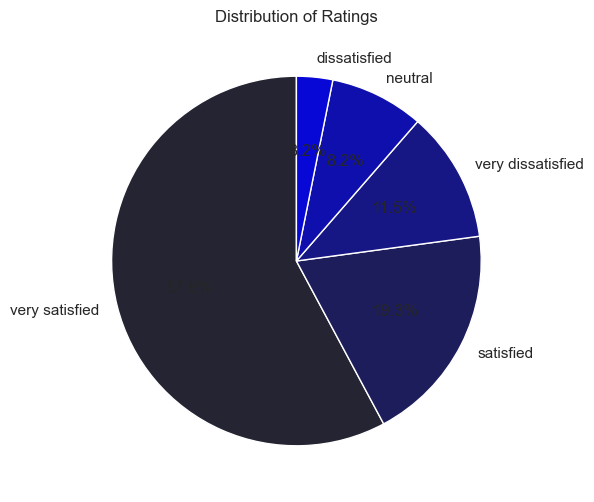

In [27]:


# Assuming you have a DataFrame named olist_order_reviews and a column named 'level_satisfaction'
order = olist_order_reviews['level_satisfaction'].value_counts().index

# Set the 'seaborn' style (optional)
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 6))
sns.countplot(x='level_satisfaction', data=olist_order_reviews, order=order, palette='dark:blue')

# Set plot labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Average Rating')

# Swap to a pie chart
plt.clf()  # Clear the previous countplot
plt.figure(figsize=(10, 6))
plt.pie(olist_order_reviews['level_satisfaction'].value_counts(), labels=order, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('dark:blue'))

# Set plot title
plt.title('Distribution of Ratings')

# Show the pie chart
plt.show()


C:\Users\trime\AppData\Local\Temp\ipykernel_11480\1084444853.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




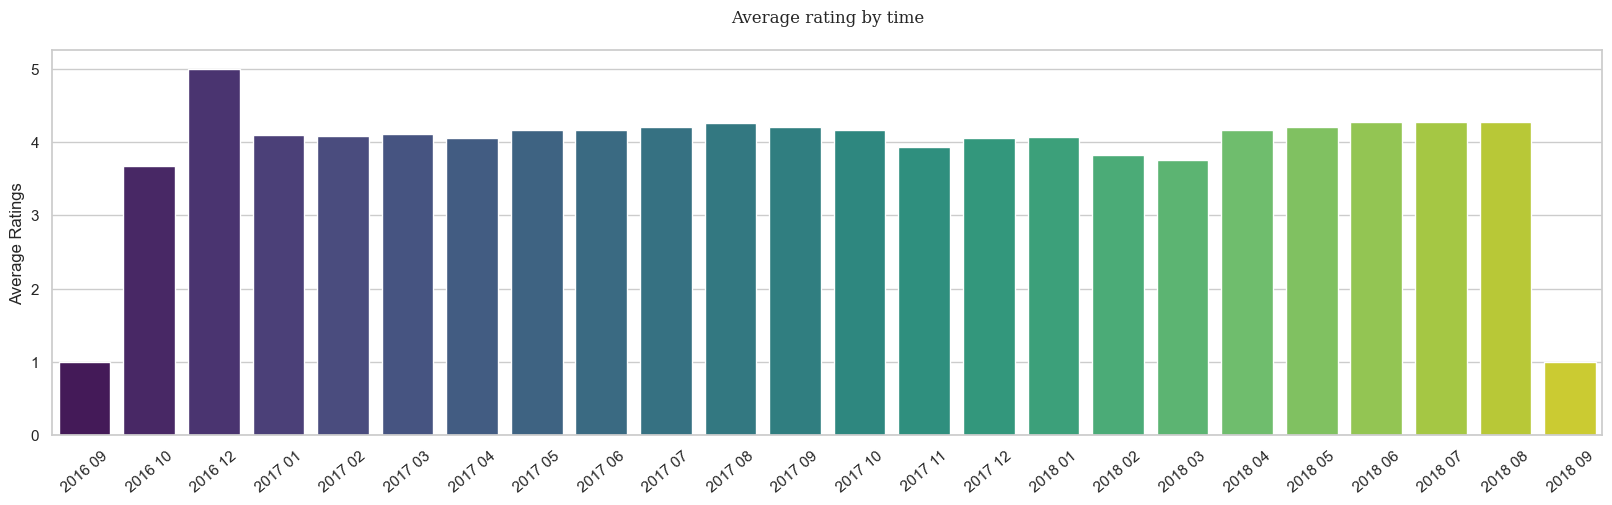

In [28]:
avg_rating_by_year_month = olist.groupby('order_purchase_year_month')['review_score'].mean().reset_index()
avg_rating_by_year_month['review_score'] = avg_rating_by_year_month['review_score'].apply(lambda x: round(x, 2))
#
plt.figure(figsize=(20,5))
sns.barplot(data = avg_rating_by_year_month,x='order_purchase_year_month', y='review_score',label='Average Rating', palette='viridis')
plt.title('Average rating by time', size=14, font='serif', pad=20)
plt.xlabel("")
plt.ylabel("Average Ratings")
plt.xticks(rotation=40)
plt.show()

In [29]:
avg_score_per_category = olist.groupby('product_category_name_english', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['Product Category', 'Number of Reviews', 'Average Review Ratings']
avg_score_per_category['Average Review Ratings'] = avg_score_per_category['Average Review Ratings'].apply(lambda x: round(x, 2))

# filtering to show only top categories with more than 100 reviews
avg_score_per_category = (avg_score_per_category[avg_score_per_category['Number of Reviews'] > 100]
                          .sort_values(by='Number of Reviews', ascending=False)[:20])

fig = px.bar(avg_score_per_category, x='Product Category', y='Number of Reviews',
             hover_data=['Average Review Ratings'], color='Average Review Ratings')

fig.update_layout(
    title=dict(text='Rating by product categories', font=dict(size=15, family='serif')),
    width=1050, height=400, 
    margin=dict(l=10, r=0, t=30, b=0),
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)
fig.show()

## 6: Payment Type Analysis

In [30]:
def normalize_payment_installments(x):
    if x in range(1, 11):
        return str(x)
    else:
        return 'Others'
        
olist['payment_installments_normalized'] = olist['payment_installments'].apply(normalize_payment_installments)
payment_installments_distribution = olist['payment_installments_normalized'].value_counts().reset_index()

In [31]:
payment_installments_distribution

,payment_installments_normalized,count
0,1,47166
1,2,11864
2,3,10062
3,4,6853
4,10,5115
5,5,5045
6,8,4139
7,6,3771
8,7,1556
9,9,615


In [32]:
payment_type_counts = (olist.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False)
                          .count()
                          .sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False]))
payment_type_counts

,order_purchase_year_month,payment_type,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,review_response_time,time_to_delivery,delivery_against_estimated,product_volume_cm,order_purchase_year,order_purchase_hour,order_purchase_month,order_purchase_dayofweek,year,month,date,total_revenue,payment_installments_normalized
0,2016 09,Credit Card,2,2,2,2,2,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2,2
2,2016 10,Credit Card,238,238,238,238,238,213,210,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,0,167,238,238,238,238,238,238,238,238,238,238,238,238,238,238,238,210,210,238,238,238,238,238,238,238,238,238,238
1,2016 10,Boleto,55,55,55,55,55,49,48,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,0,43,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,48,48,55,55,55,55,55,55,55,55,55,55
4,2016 10,Voucher,7,7,7,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,0,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,7,7,7,7,7,7,7,7,7,7
3,2016 10,Debit Card,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2018 08,Credit Card,4877,4877,4877,4877,4877,4837,4806,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,1736,1811,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877,4806,4806,4877,4877,4877,4877,4877,4877,4877,4877,4877,4877
82,2018 08,Boleto,1122,1122,1122,1122,1122,1112,1106,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,414,426,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,1106,1106,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122
84,2018 08,Debit Card,273,273,273,273,273,273,267,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,111,119,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,267,267,273,273,273,273,273,273,273,273,273,273
85,2018 08,Voucher,121,121,121,121,121,120,119,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,45,41,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,119,119,121,121,121,121,121,121,121,121,121,121


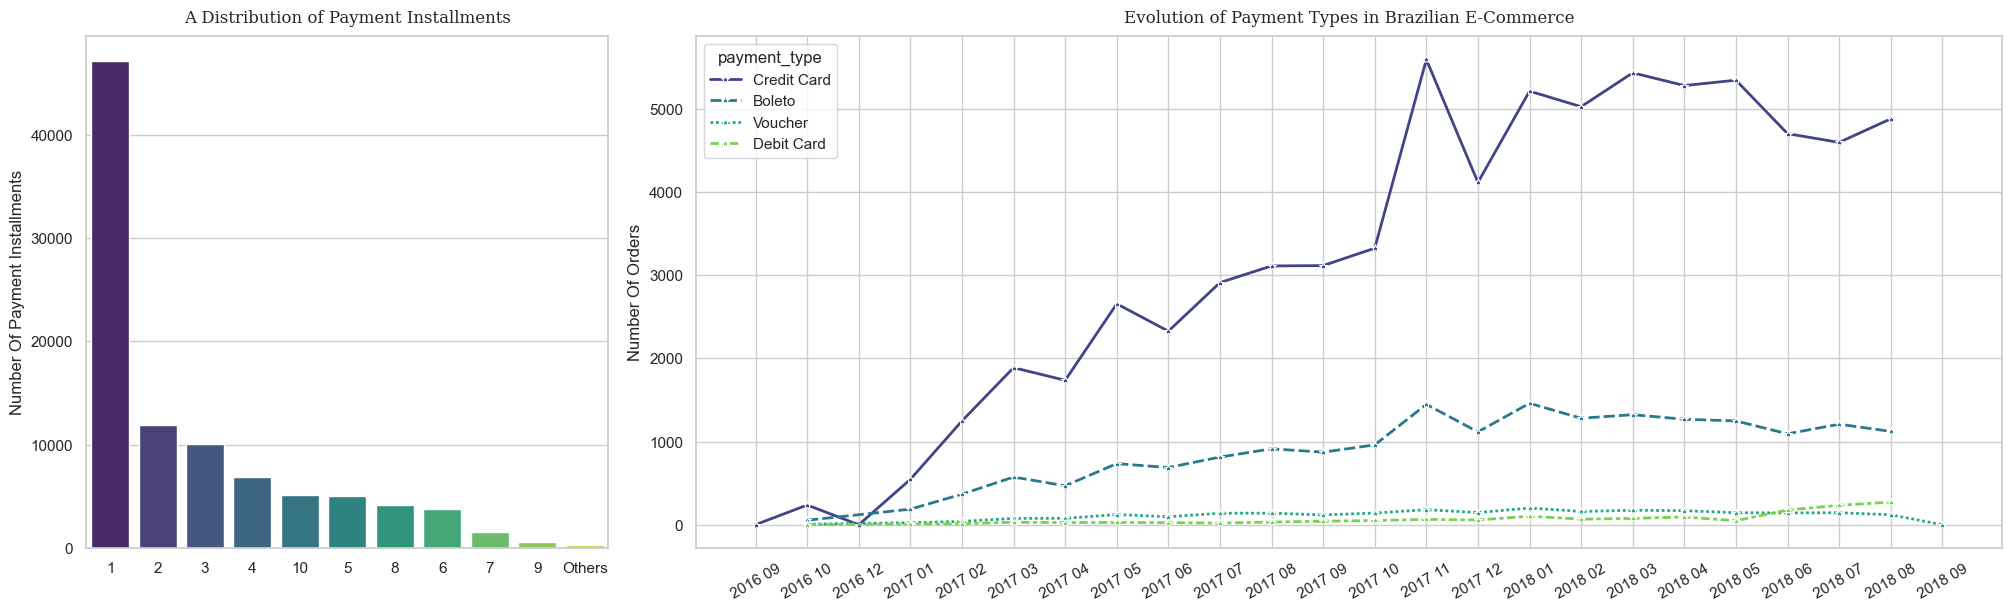

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 5]})

# Plot 1 - Distribution of Payment Installments
payment_installments_distribution = olist['payment_installments_normalized'].value_counts().reset_index()
sns.barplot(data=payment_installments_distribution, x='payment_installments_normalized', y='count', palette='viridis', ax=ax1)
ax1.set_title('A Distribution of Payment Installments', size=14, font='serif', pad=10)
ax1.set_ylabel('Number Of Payment Installments')
ax1.set_xlabel('')

# Plot 2 - Evolution of payment types
payment_type_evolution = (olist.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False)
                          .count()
                          .sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False]))

sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_type_evolution, ax=ax2, hue='payment_type',
             style='payment_type', palette='viridis', marker='*', linewidth=2)
ax2.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=14, font='serif', pad=10)
plt.xticks(rotation=30)
ax2.set_xlabel('')
ax2.set_ylabel('Number Of Orders')
plt.show()

## 8: Number of orders per state

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\1810117596.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0, 'State')

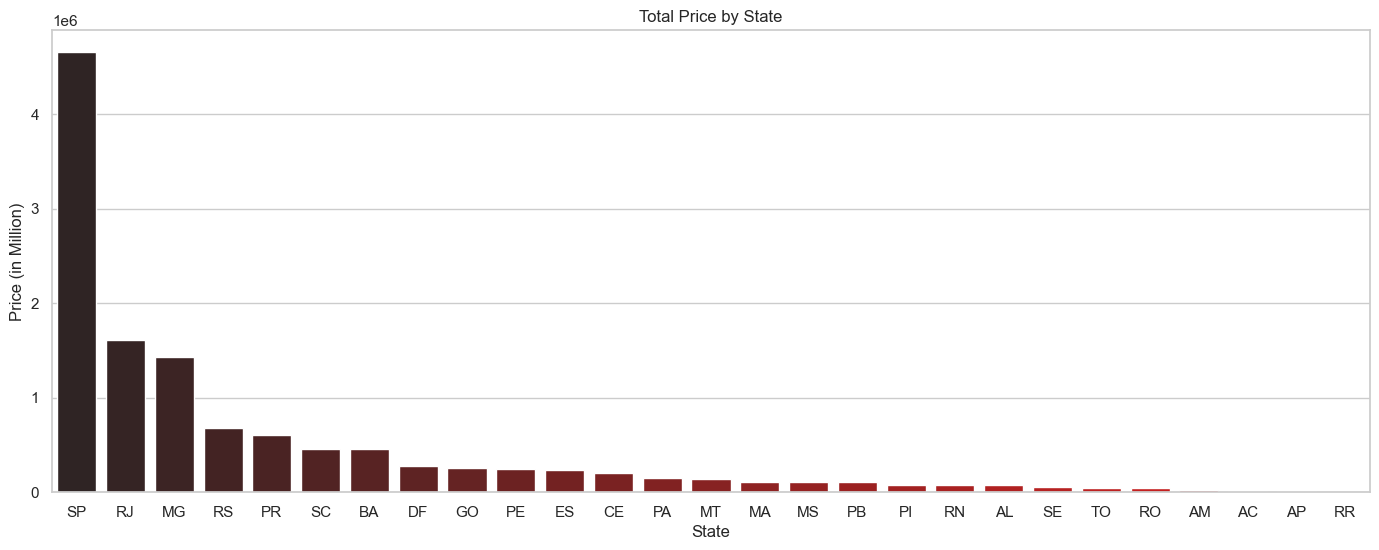

In [34]:
totalByState = olist.groupby('customer_state')['price'].sum().sort_values(ascending=False)

plt.figure(figsize=(17,6))
plt.title('Total Price by State')
sns.barplot(x=totalByState.index, y=totalByState,palette='dark:red')
plt.ylabel('Price (in Million)')
plt.xlabel('State')

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\498049320.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0, 'State')

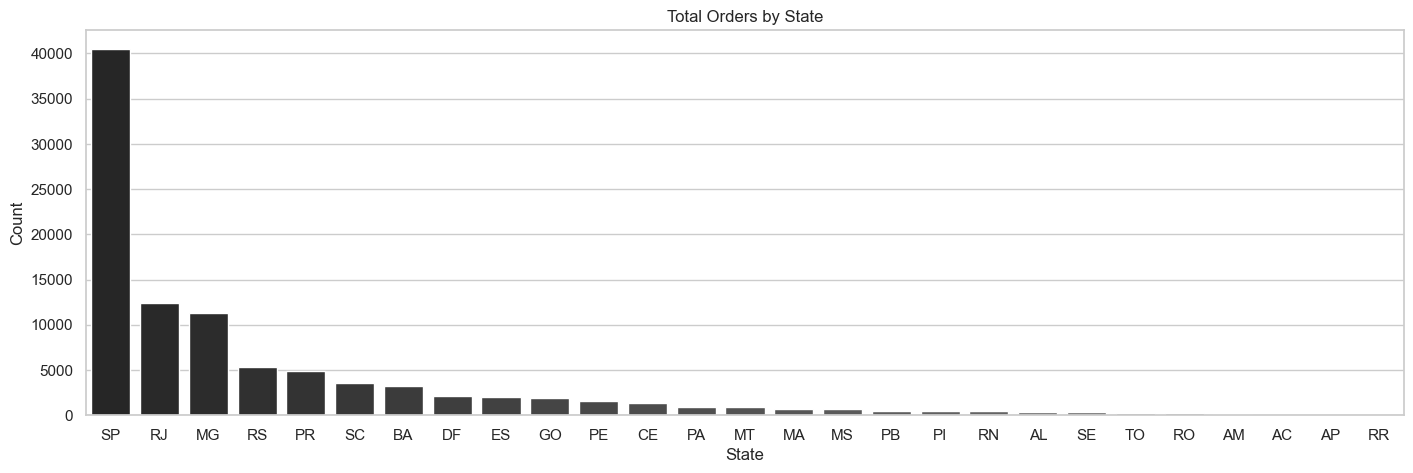

In [35]:
totalOrdersByState = olist.groupby('customer_state')['order_id'].nunique().sort_values(ascending=False)
totalOrdersByState

plt.figure(figsize=(17,5))
plt.title('Total Orders by State')
sns.barplot(x=totalOrdersByState.index, y=totalOrdersByState,palette='dark:gray')
plt.ylabel('Count')
plt.xlabel('State')

C:\Users\trime\AppData\Local\Temp\ipykernel_11480\624815048.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0, 'State')

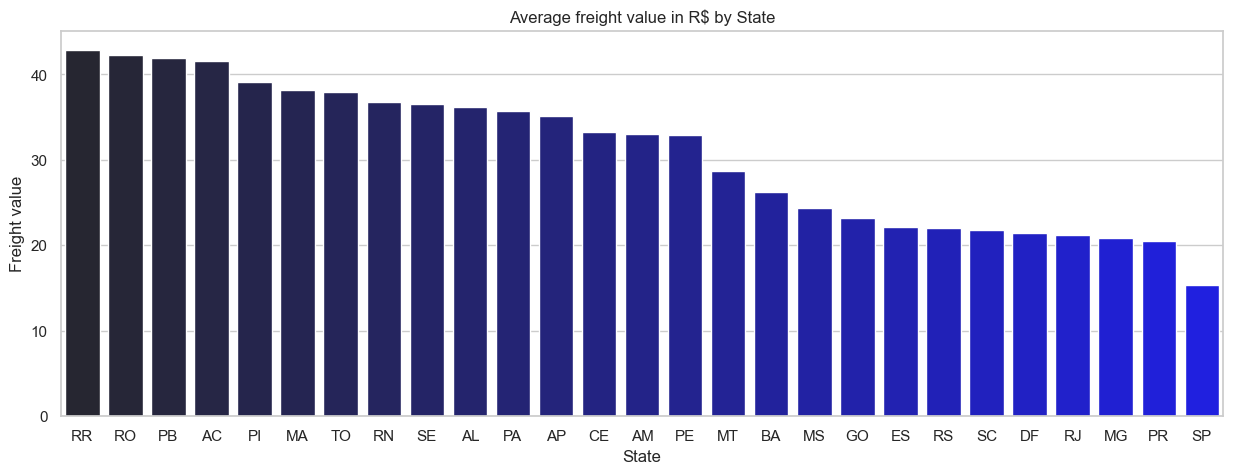

In [36]:
freightAvgState = (olist.groupby('customer_state')['freight_value'].sum() /olist.groupby('customer_state')['order_id'].nunique()).sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('Average freight value in R$ by State')
sns.barplot(x=freightAvgState.index, y=freightAvgState,palette='dark:blue')
plt.ylabel('Freight value')
plt.xlabel('State')

## 9: Average Delivery Time

In [37]:
olist['delivery_time'] = (olist['order_delivered_customer_date'] - olist['order_approved_at']).dt.total_seconds() / 86.400
olist['estimated_delivery_time'] = (olist['order_estimated_delivery_date'] - olist['order_approved_at']).dt.total_seconds() / 86.400

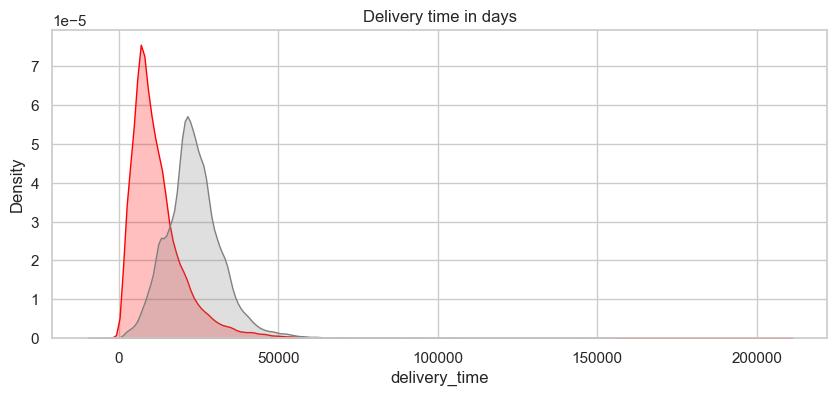

In [38]:
# Delivery estimated time and actual delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
ax1 = sns.kdeplot(olist['delivery_time'].dropna(), color="red", label='Delivery time', fill=True)
ax2 = sns.kdeplot(olist['estimated_delivery_time'].dropna(), color="grey", label='Estimated delivery time',fill=True)

# RFM Analysis

## Customer distribution by purchase time

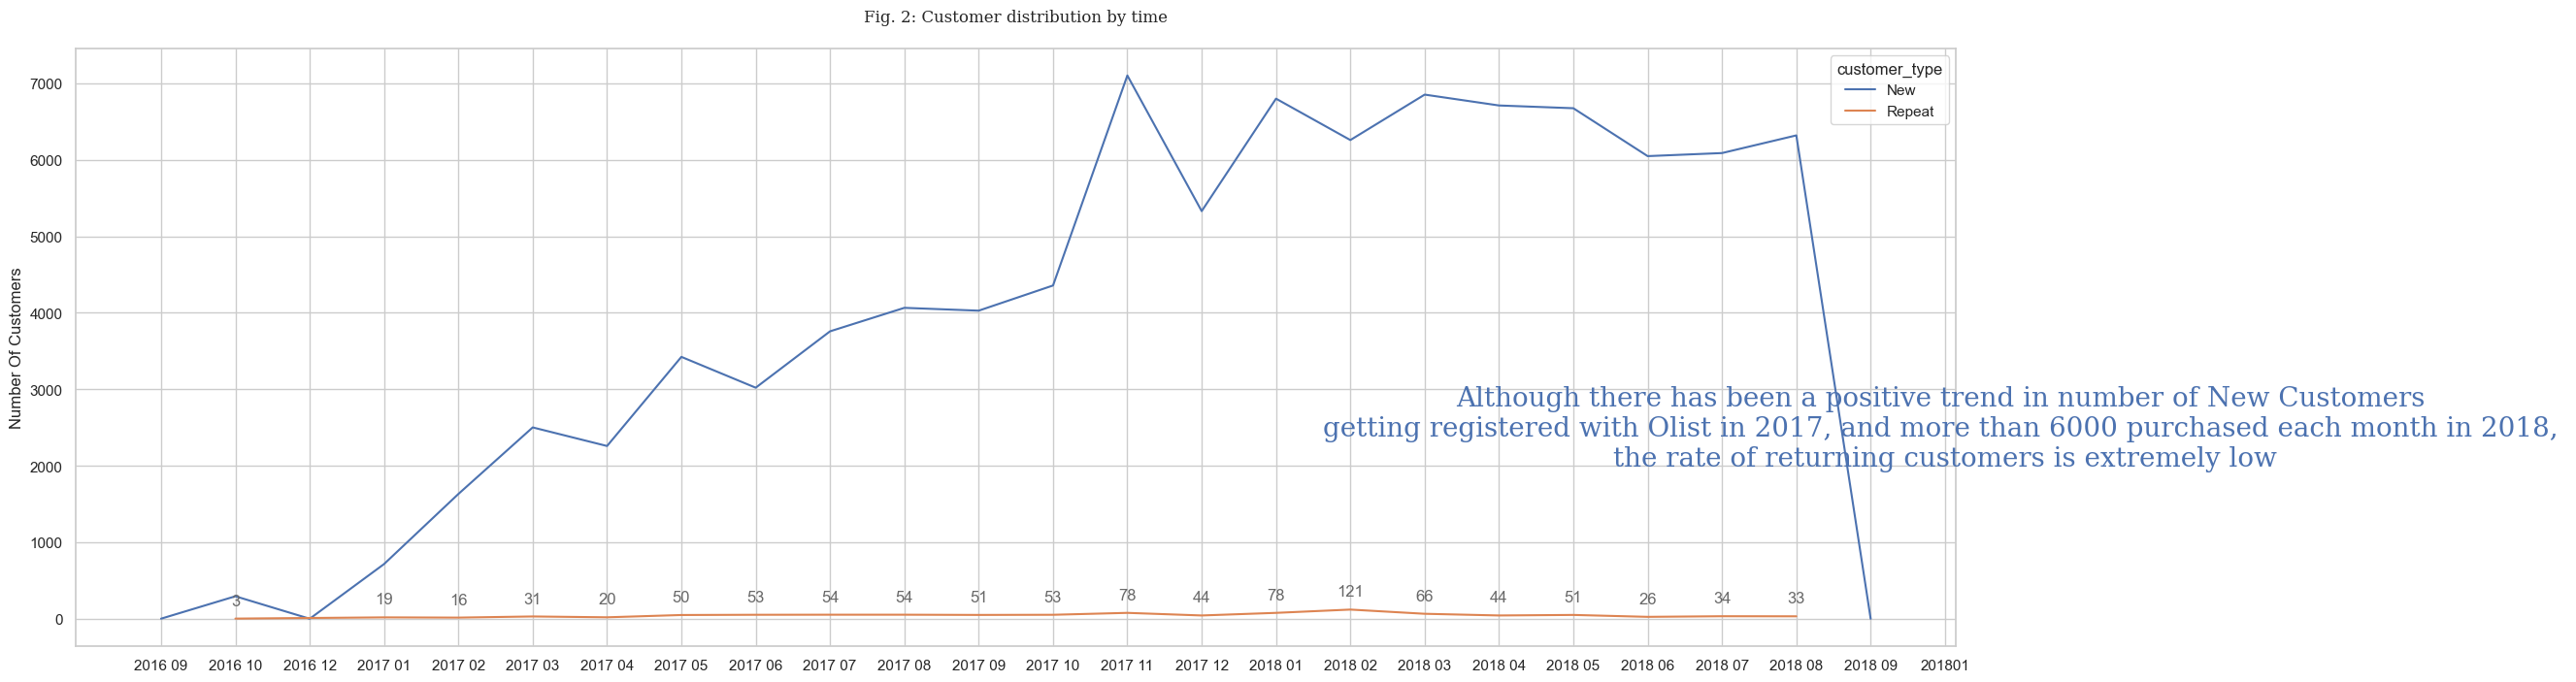

In [39]:
olist['order_purchase_date'] = olist.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
customer_by_time = olist.groupby(['customer_unique_id', 'order_purchase_year_month']).agg({'order_purchase_date': ['nunique', 'first']})
customer_by_time.columns = ['num_of_orders', 'order_first_purchase_date']
customer_by_time['customer_type'] = customer_by_time['num_of_orders'].apply(lambda x: 'Repeat' if x > 1 else 'New')

customer_by_time = customer_by_time.reset_index().groupby(['order_purchase_year_month', 'customer_type'])['customer_unique_id'].count().reset_index()
customer_by_time['order_purchase_year_month'] = customer_by_time.order_purchase_year_month.astype(str)

# Plot
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=customer_by_time, x='order_purchase_year_month', y='customer_unique_id', hue='customer_type')
for x, y in customer_by_time.loc[customer_by_time.customer_type == 'Repeat', ['order_purchase_year_month', 'customer_unique_id']].values:
    ax.annotate(str(y), xy=(x, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')

ax.set_title('Fig. 2: Customer distribution by time', size=14, font='serif', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Number Of Customers')
comment = 'Although there has been a positive trend in number of New Customers \ngetting registered with Olist in 2017, and more than 6000 purchased each month in 2018, \nthe rate of returning customers is extremely low'
plt.text(x='201801', y=2000, s=comment, family='serif', color='b', fontsize=20, ha='center')
plt.show()

## RFM analysis

In [40]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from operator import attrgetter
from datetime import timedelta, datetime

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [41]:
present_day = olist['order_purchase_timestamp'].max()+ dt.timedelta(days=2)

print("Present day: ",present_day)

Present day:  2018-09-05 09:06:57


In [42]:
print("Latest date in dataset: ", olist['order_purchase_timestamp'].max())

Latest date in dataset:  2018-09-03 09:06:57


In [43]:
recency_df= pd.DataFrame(olist.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
93392,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
93393,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
93394,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


In [44]:
rfm= olist.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (present_day - date.max()).days,
                                        'order_id': lambda num: len(num), 
                                        'payment_value': lambda price: price.sum()})

In [45]:
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(int)
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27
0000f46a3911fa3c0805444483337064,543,1,86
0000f6ccb0745a6a4b88665a16c9f078,327,1,43
0004aac84e0df4da2b147fca70cf8255,294,1,196


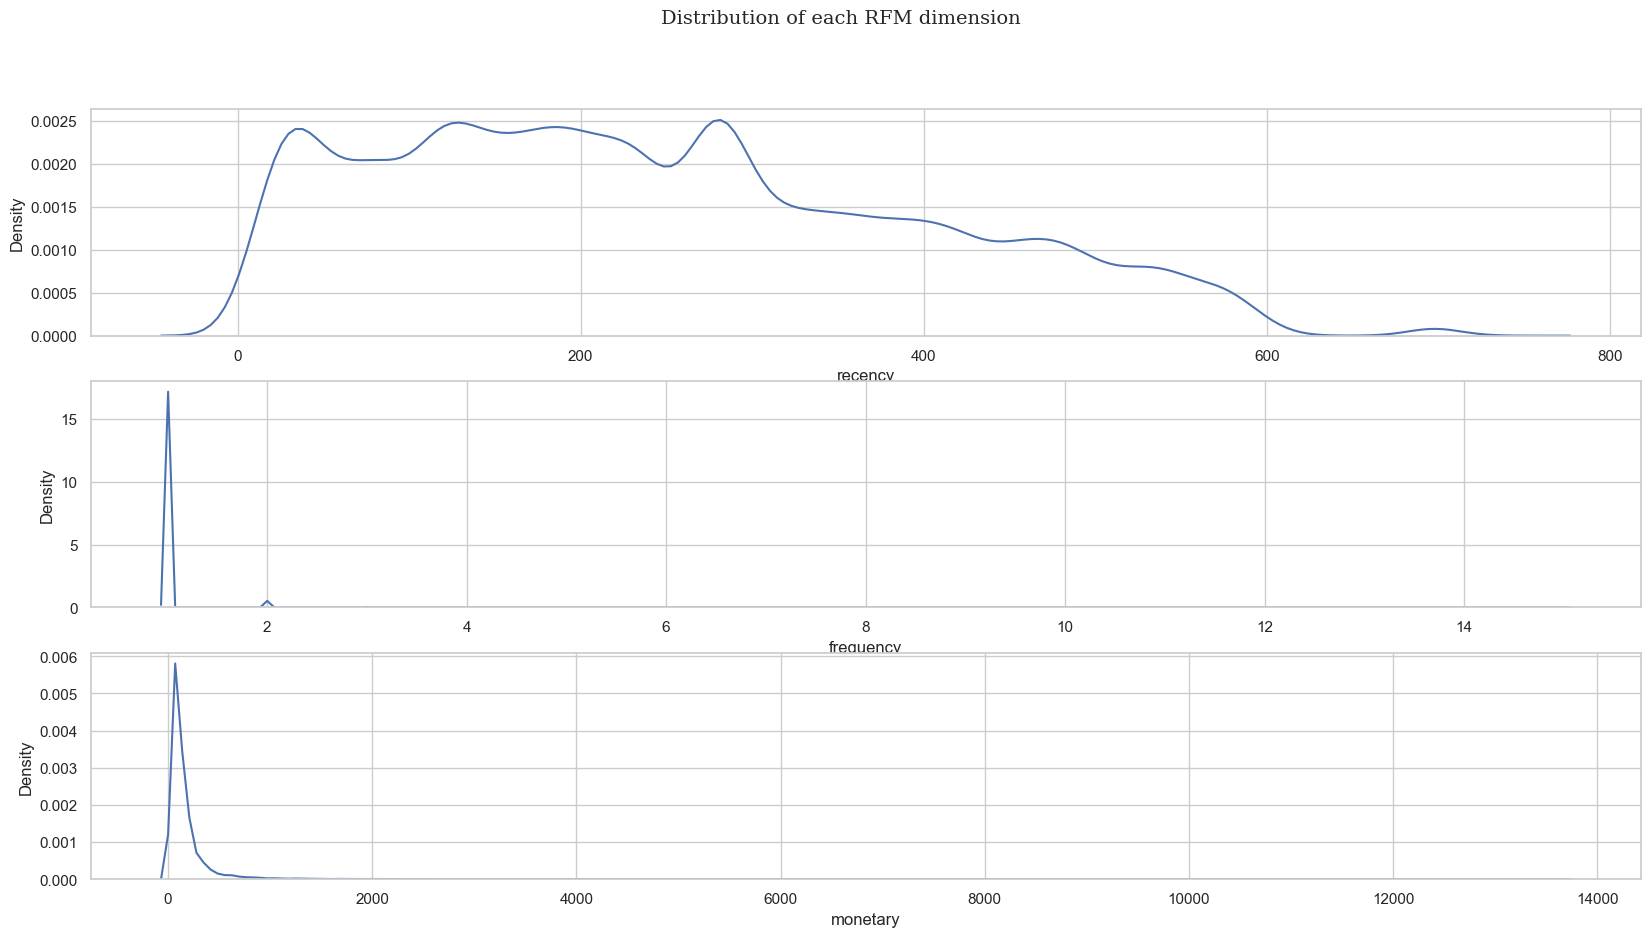

In [65]:
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
sns.kdeplot(rfm['recency'])

plt.subplot(3, 1, 2)
sns.kdeplot(rfm['frequency'])

plt.subplot(3, 1, 3)
sns.kdeplot(rfm['monetary'])
plt.suptitle('Distribution of each RFM dimension', size=14, font='serif')
plt.show()

In [47]:
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm['recency'], q=4, labels=r_labels)

f_labels = range(1, 5)
f_groups = pd.cut(rfm['frequency'], bins=[0, 1, 2, 3, max(rfm['frequency'])], labels=f_labels)

m_labels = range(1, 5)
m_groups = pd.qcut(rfm['monetary'], q=4, labels=m_labels)

rfm = rfm.assign(
    R=r_groups.values, 
    F=f_groups.values,
    M=m_groups.values
)
rfm.head()

,recency,frequency,monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27,4,1,1
0000f46a3911fa3c0805444483337064,543,1,86,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,327,1,43,2,1,1
0004aac84e0df4da2b147fca70cf8255,294,1,196,2,1,4


## RFM Scorce

In [48]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 97.0, 0.4: 182.0, 0.6: 274.0, 0.8: 389.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 53.0, 0.4: 85.0, 0.6: 130.0, 0.8: 207.0}}

In [49]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [50]:
# Calculate RFM score for each customer

rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [51]:
# Combine the scores
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27,4,1,1,411
0000f46a3911fa3c0805444483337064,543,1,86,1,1,3,113
0000f6ccb0745a6a4b88665a16c9f078,327,1,43,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,294,1,196,2,1,4,214


In [75]:
#Creating dictionary with scores and segment names
segments = {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating Customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [76]:
#Creating segment column
rfm['segment'] = rfm['RFM Score'].replace(segments, regex=True)

#Show results
rfm.head()

,recency,frequency,monetary,R,F,M,RFM Score,segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27,4,1,1,411,New Customers
0000f46a3911fa3c0805444483337064,543,1,86,1,1,3,113,Cannot Lose Them
0000f6ccb0745a6a4b88665a16c9f078,327,1,43,2,1,1,211,Hibernating Customers
0004aac84e0df4da2b147fca70cf8255,294,1,196,2,1,4,214,Cannot Lose Them


In [54]:
#Calculate some calculations grouping each segment
rfm_statistics = rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(['mean','median', 'min', 'max', 'count'])

#Show results
rfm_statistics

recency                         frequency         \
                             mean median  min  max  count      mean median   
segment                                                                      
About To Sleep         273.947164  274.0  183  389   7211  1.001109    1.0   
At Risk                348.284404  335.0  275  607    654  2.077982    2.0   
Cannot Lose Them       417.951095  415.0  275  730  17667  1.019471    1.0   
Champions               93.695297   93.0    2  182    978  2.177914    2.0   
Hibernating customers  323.063929  320.0  275  389   7524  1.000000    1.0   
Lost customers         480.298437  473.0  390  730   7804  1.002050    1.0   
Loyal                  222.934394  220.0  183  274    503  2.109344    2.0   
New Customers          122.854181  121.0    6  274  18331  1.000000    1.0   
Potential Loyalist     135.644377  135.0    7  274    329  2.024316    2.0   
Promising              138.853712  138.0    6  274  32395  1.000000    1.0   

                                        monetary                            
                      min max  count        mean median  min    max  count  
segment                                                                     
About To Sleep          1   3   7211   86.880599   85.0   34    130   7211  
At Risk                 2   6    654  268.024465  181.0   56   3064    654  
Cannot Lose Them        1   4  17667  265.107885  181.0   86  13664  17667  
Champions               2  15    978  370.230061  269.0  131   4655    978  
Hibernating customers   1   1   7524   53.611377   55.0    0     85   7524  
Lost customers          1   3   7804   52.774859   53.0    0     85   7804  
Loyal                   2   9    503  338.333996  257.0  131   2164    503  
New Customers           1   1  18331   49.195789   47.0    0     85  18331  
Potential Loyalist      2   3    329   93.121581   98.0    7    130    329  
Promising               1   1  32395  229.429480  159.0   86   7274  32395

In [55]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()

                      recency frequency monetary       
                         mean      mean     mean  count
segment                                                
About To Sleep          273.9       1.0     86.9   7211
At Risk                 348.3       2.1    268.0    654
Cannot Lose Them        418.0       1.0    265.1  17667
Champions                93.7       2.2    370.2    978
Hibernating customers   323.1       1.0     53.6   7524
Lost customers          480.3       1.0     52.8   7804
Loyal                   222.9       2.1    338.3    503
New Customers           122.9       1.0     49.2  18331
Potential Loyalist      135.6       2.0     93.1    329
Promising               138.9       1.0    229.4  32395


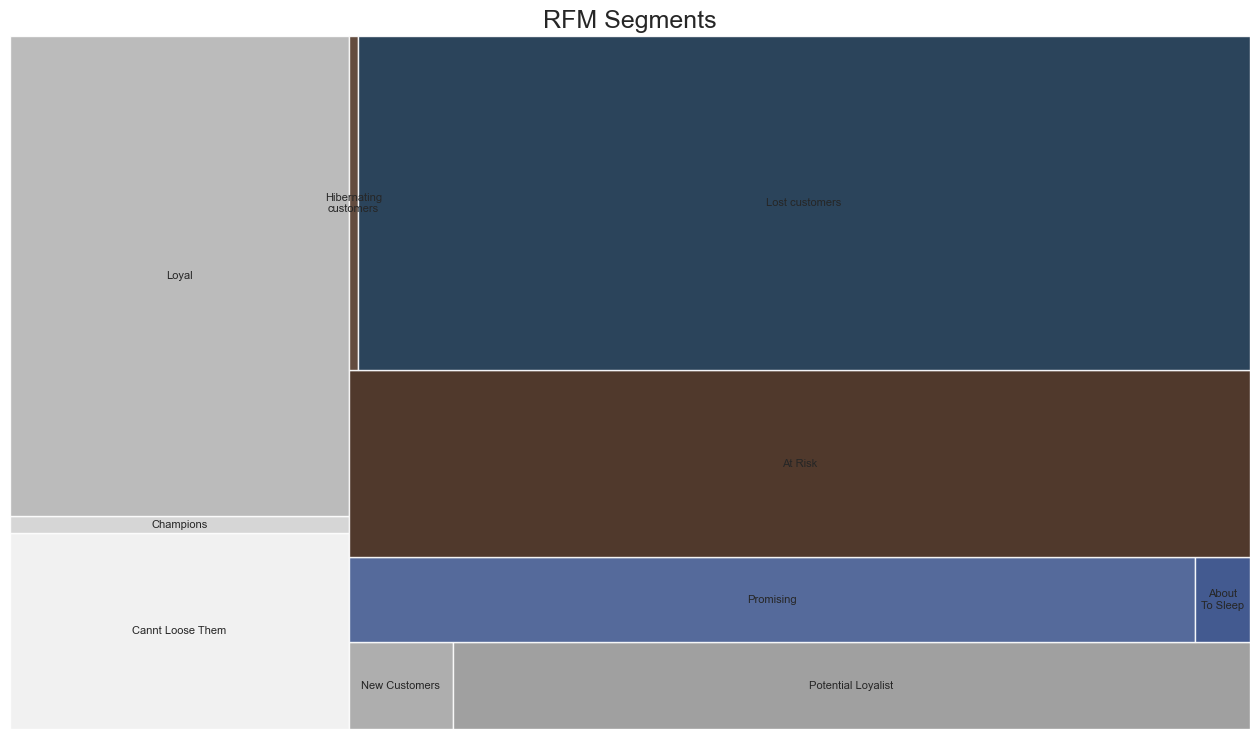

In [78]:
import squarify

rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Cannt Loose Them',
                     'Champions',
                     'Loyal',
                     'New Customers',
                     'Potential Loyalist', 
                     'Promising',
                     'About\nTo Sleep',
                     'At Risk',
                     'Hibernating\ncustomers',
                     'Lost customers'
                     ], alpha=.9,color=['#f0f0f0', '#d2d2d2', '#b4b4b4', '#a5a5a5', '#969696', '#425a90', '#2e4884','#3D2315','#52382A','#142F49'],
                     text_kwargs={'fontsize': 8}  # Adjust font size and rotation

)
plt.title("RFM Segments",fontsize=18)
plt.axis('off')
plt.show()

# K-Means clustering

# Apply K-Means Clustering to Model

In [57]:
# Filter R, F, M dimension only
rfm_df = rfm[['recency', 'frequency', 'monetary']]

# Scale data
rfm_df_log = rfm_df.apply(lambda x: np.log1p(x))
scaler = StandardScaler().fit(rfm_df_log)
# Scale data
scaler = StandardScaler().fit(rfm_df_log)
rfm_scaled = scaler.transform(rfm_df_log)
rfm_scaled = pd.DataFrame(data=rfm_scaled, index=rfm_df.index, columns=rfm_df.columns)
kmeans = KMeans(n_clusters=5, random_state=42).fit(rfm_scaled)
cluster_labels = kmeans.labels_

# Results
rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
rfm_df_with_cluster_grouped


recency frequency monetary       
           mean      mean     mean  count
Cluster                                  
0         282.3       1.0     47.7  26254
1         244.1       1.0    499.6  12654
2         309.1       1.0    135.2  34856
3         226.8       2.1    305.2   2807
4          50.7       1.0    122.1  16825

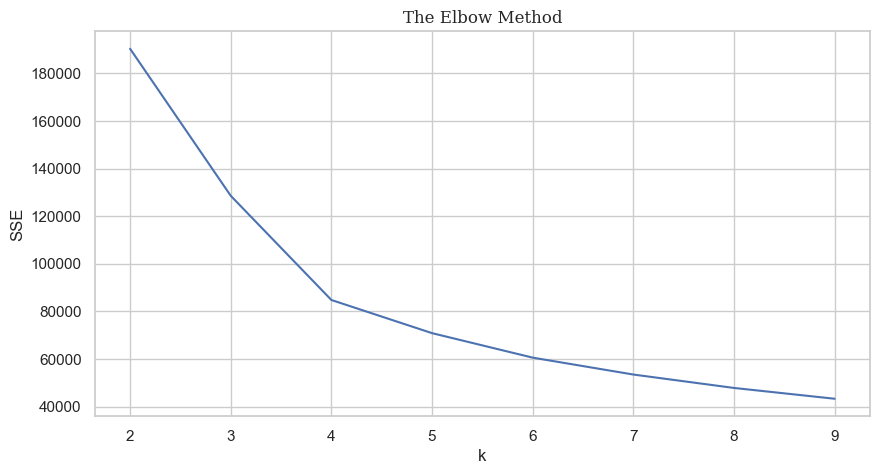

In [58]:
sse = {}
for k in range(2, 10):  
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(10, 5))

plt.title('The Elbow Method', size=14, font='serif')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(sse.keys(), sse.values())
plt.show()

## K-Means Model

In [59]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42).fit(rfm_scaled)
cluster_labels = kmeans.labels_

rfm_df_with_cluster = rfm_df.assign(Cluster=cluster_labels)
rfm_df_with_cluster_grouped = rfm_df_with_cluster.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
rfm_df_with_cluster

,recency,frequency,monetary,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141,4
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27,0
0000f46a3911fa3c0805444483337064,543,1,86,1
0000f6ccb0745a6a4b88665a16c9f078,327,1,43,0
0004aac84e0df4da2b147fca70cf8255,294,1,196,1
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,453,1,2067,5
fffea47cd6d3cc0a88bd621562a9d061,268,1,84,1
ffff371b4d645b6ecea244b27531430a,574,1,112,1


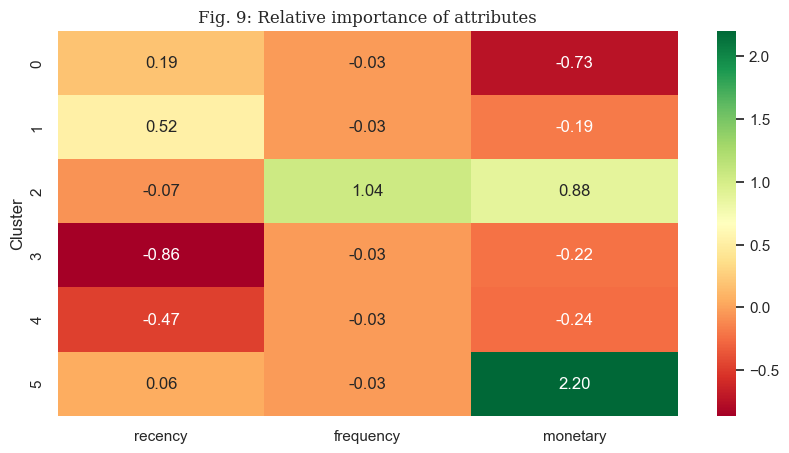

In [60]:
cluster_avg = rfm_df_with_cluster.groupby(['Cluster']).mean() 
population_avg = rfm_df.mean()
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(10, 5))
plt.title('Fig. 9: Relative importance of attributes', size=14, font='serif')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()